In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split as ts
from geopy.distance import geodesic
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data = pd.read_csv('UPLOAD TRAIN DATASET')

In [ ]:
test_data = pd.read_csv('UPLOAD TEST DATASET')

In [4]:
train_data['distance_km'] = train_data.apply(
    lambda x: geodesic(
        (x['Restaurant_latitude'], x['Restaurant_longitude']),
        (x['Delivery_location_latitude'], x['Delivery_location_longitude'])
    ).km, axis=1)

In [5]:
test_data['distance_km'] = test_data.apply(lambda x: geodesic(
    (x['Restaurant_latitude'], x['Restaurant_longitude']),
    (x['Delivery_location_latitude'], x['Delivery_location_longitude'])
).km, axis=1)

In [6]:
train_data = train_data.dropna(subset=['Time_taken(min)'])
train_data.fillna(train_data.median(numeric_only=True), inplace=True)

In [7]:
features = [
    'Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
    'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries',
    'Festival', 'City', 'Weatherconditions', 'Road_traffic_density',
    'distance_km'
]
target = 'Time_taken(min)'

In [8]:
train_data['Time_taken(min)'] = train_data['Time_taken(min)'].astype(str).str.extract(r'(\d+\.?\d*)')[0]

In [9]:
train_data['Time_taken(min)'] = pd.to_numeric(train_data['Time_taken(min)'], errors='coerce')

In [10]:
print(train_data['Time_taken(min)'].dtype)
print(train_data['Time_taken(min)'].unique()[:10])
print(train_data['Time_taken(min)'].head())


int64
[24 33 26 21 30 40 32 34 46 23]
0    24
1    33
2    26
3    21
4    30
Name: Time_taken(min), dtype: int64


In [11]:
train_data = train_data.dropna(subset=['Time_taken(min)'])
y_train = train_data['Time_taken(min)']

In [12]:
x_train = pd.get_dummies(train_data[features], drop_first=True)
y_train = pd.to_numeric(train_data['Time_taken(min)'], errors='coerce')

x_train = x_train.loc[y_train.notnull()]
y_train = y_train.dropna()

In [13]:
print(x_train.shape, y_train.shape)


(45593, 77) (45593,)


In [14]:
# Prepare test data
x_test = pd.get_dummies(test_data[features], drop_first=True)

# Align columns in case some categories are missing in test or train
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [15]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
test_predictions = model.predict(x_test)
test_data['Predicted_Time_taken(min)'] = test_predictions

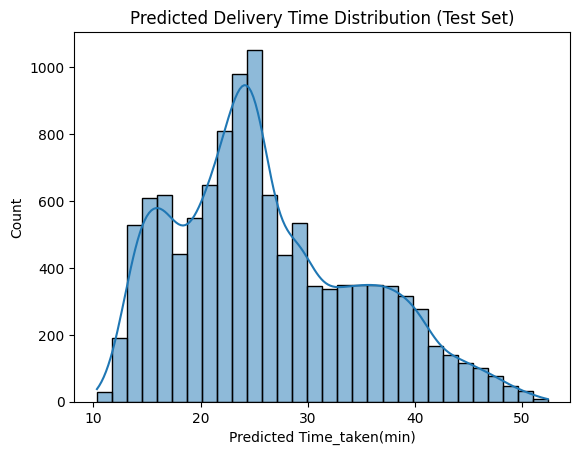

In [17]:
sns.histplot(test_data['Predicted_Time_taken(min)'], bins=30, kde=True)
plt.title('Predicted Delivery Time Distribution (Test Set)')
plt.xlabel('Predicted Time_taken(min)')
plt.show()

In [21]:
x_train, x_val, y_train, y_val = ts(x_train, y_train, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
y_val_pred = model.predict(x_val)

In [22]:
print(f"RMSE: {root_mean_squared_error(y_val, y_val_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.3f}")
print(f"R²: {r2_score(y_val, y_val_pred):.3f}")


RMSE: 4.211
MAE: 3.289
R²: 0.800
